In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
fnames = [f for f in os.listdir('..') if f.startswith('TDA_anomaly_diff')]
fnames

['TDA_anomaly_diff_3.npy', 'TDA_anomaly_diff_1.npy', 'TDA_anomaly_diff_2.npy']

In [5]:
dicts = {fname.replace('.npy',''):np.load('../'+fname, allow_pickle=True).item() for fname in fnames}

In [6]:
tda_ds = pd.DataFrame(dicts)
tda_ds = tda_ds[sorted(tda_ds.columns)]
tda_ds.index.name = 'Country'
print(tda_ds.shape)
tda_ds.head()

(188, 3)


,TDA_anomaly_diff_1,TDA_anomaly_diff_2,TDA_anomaly_diff_3
Country,,,
Afghanistan,class 1,class_1,class_2
Albania,class 1,class_1,class_2
Algeria,class 1,class_1,class_1
Andorra,class 1,class_5,NaN
Angola,class 1,class_1,class_1


In [7]:
for f in tda_ds.columns:
    tda_ds[f] = [int(x.replace('class','').replace('_','')) if x is not np.nan else None for x in tda_ds[f]]
    tda_ds[f] = tda_ds[f].fillna(tda_ds[f].dropna().max()+1)

In [8]:
cov_ds = pd.read_csv('../Covid_19_aggregated.csv')
print(cov_ds.shape)
cov_ds.head()

(28952, 60)


,Country,Lat,Long,Date,Confirmed,Deaths,Recovered,C1_School closing,C2_Workplace closing,C3_Cancel public events,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,Population,GrowthRate,Area,Density,Airports,GDP
0,Afghanistan,33.0,65.0,01/22/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0
1,Afghanistan,33.0,65.0,01/23/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0
2,Afghanistan,33.0,65.0,01/24/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0
3,Afghanistan,33.0,65.0,01/25/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0
4,Afghanistan,33.0,65.0,01/26/2020,0,0,0,0.0,0.0,0.0,...,NaN,37.746,0.5,64.83,38041.754,1.0233,652230.0,58.3257,22.0,74792.0


In [9]:
cov_ds = cov_ds.merge(tda_ds.reset_index())

In [10]:
cov_ds['Date_dt'] = pd.to_datetime(cov_ds['Date'])

In [11]:
tda_ds.columns

Index(['TDA_anomaly_diff_1', 'TDA_anomaly_diff_2', 'TDA_anomaly_diff_3'], dtype='object')

In [12]:
cov_ds['Confirmed_lag1'] = None
for v in cov_ds['Country'].unique():
    cds = cov_ds[cov_ds['Country']==v].sort_values('Date_dt')
    cov_ds.loc[cds.index, 'Confirmed_lag1'] = cds['Confirmed'].shift(1)
#cov_ds['Confirmed_lag1'] = cds['Confirmed'].shift(1)

In [13]:
cov_ds['Confirmed_diff'] = cov_ds['Confirmed']-cov_ds['Confirmed_lag1']

In [14]:
cov_ds = cov_ds[cov_ds['Date_dt']>'2020-01-22']

In [15]:
cov_ds['Confirmed_diff'] = cov_ds['Confirmed_diff'].astype(float)

In [16]:
for f in ['Confirmed','Deaths','Recovered', 'Confirmed_diff']:
    cov_ds[f"{f}_per_kpop"] = cov_ds[f]/cov_ds['Population']
    cov_ds[f"{f}_per_pop"] = cov_ds[f]/cov_ds['Population']/1000
    cov_ds[f"{f}_per_pop_perc"] = cov_ds[f]/cov_ds['Population']/1000*100
    cov_ds[f"{f}_log"] = np.log1p(cov_ds[f])

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log1p
  """
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [17]:
xticks = list(cov_ds['Date_dt'].sort_values().drop_duplicates())[::7]

In [18]:
yticks = np.array([0,1,3,10,30,100,300, 1000,3000, 10000, 30000])

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


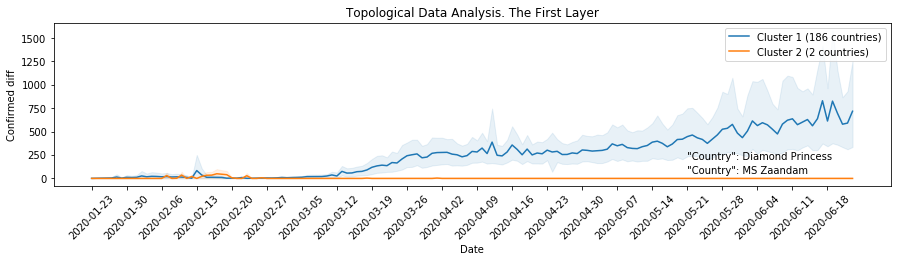

In [19]:
plt.figure(figsize=(15,3))
f = 'TDA_anomaly_diff_1'
for v in tda_ds[f].value_counts().index:
    sns.lineplot(x='Date_dt', y='Confirmed_diff', data=cov_ds[cov_ds[f]==v],
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries)", palette='Accent',
                err_kws={'alpha':0.1})
plt.xticks(xticks, [str(x)[:10] for x in xticks], rotation=45)
#plt.yticks(np.log1p(yticks), yticks)
for idx, txt in enumerate(['Diamond Princess','MS Zaandam']):
    plt.text(xticks[-5], 350-(1+idx)*150, f'"Country": {txt}')
plt.title(f"Topological Data Analysis. The First Layer")
plt.ylabel('Confirmed diff')
plt.xlabel('Date')
plt.show()

In [20]:
tda_ds[tda_ds[f]==2]

,TDA_anomaly_diff_1,TDA_anomaly_diff_2,TDA_anomaly_diff_3
Country,,,
Diamond Princess,2,16.0,16.0
MS Zaandam,2,16.0,16.0


In [21]:
tda_ds.loc[tda_ds['TDA_anomaly_diff_1']==2, 'TDA_final'] = 'Ships'

In [22]:
from datetime import timedelta

In [23]:
tda_ds['TDA_anomaly_diff_2'].value_counts()

1.0     162
2.0      17
3.0       3
16.0      2
9.0       1
8.0       1
15.0      1
5.0       1
Name: TDA_anomaly_diff_2, dtype: int64

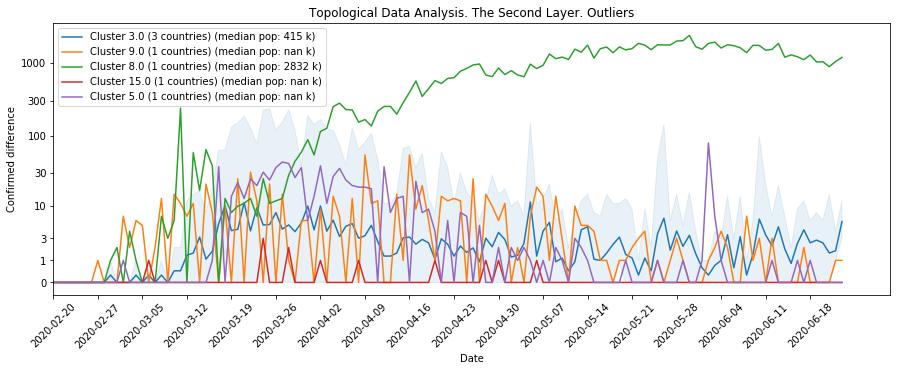

In [24]:
plt.figure(figsize=(15,5))
f = 'TDA_anomaly_diff_2'
for v in tda_ds[f].value_counts().index[2:]:
    if v==tda_ds[f].max():
        continue
    pop_mean = cov_ds[cov_ds[f]==v].groupby('Country')['Population'].mean().median()
    #sns.lineplot(x='Date_dt', y='Confirmed_log', data=cov_ds[cov_ds[f]==v],
    sns.lineplot(x='Date_dt', y='Confirmed_diff_log', data=cov_ds[cov_ds[f]==v],
    #sns.lineplot(x='Date_dt', y='Confirmed_per_pop', data=cov_ds[cov_ds[f]==v],
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries) (median pop: {pop_mean:.0f}"+" k)" if pop_mean is not None else ")",
                 palette='Accent', err_kws={'alpha':0.1})
plt.xticks(xticks[4:], [str(x)[:10] for x in xticks][4:], rotation=45)
plt.xlim((xticks[4], plt.xlim()[-1]))
plt.yticks(np.log1p(yticks[:-3]), yticks[:-3])

for v in tda_ds[f].value_counts().index[2:]:
    if v==tda_ds[f].max():
        continue
    mean = cov_ds.loc[(cov_ds[f]==v)&(cov_ds['Date_dt']==xticks[-1]), 'Confirmed_diff_log'].mean()
    cntrs = ', '.join(list(tda_ds[tda_ds[f]==v].index))
    #plt.text(xticks[-2], mean+0.1, cntrs)
    #plt.text(xticks[-1], mean+0.1, f"Confirmed cases: {np.expm1(mean):.0f}")

plt.title(f"Topological Data Analysis. The Second Layer. Outliers")
plt.ylabel('Confirmed difference')
plt.xlabel('Date')
plt.show()

In [25]:
tda_ds[tda_ds['TDA_anomaly_diff_2'].isin([3,9,15,5])]

,TDA_anomaly_diff_1,TDA_anomaly_diff_2,TDA_anomaly_diff_3,TDA_final
Country,,,,
Andorra,1,5.0,16.0,NaN
Holy See,1,15.0,16.0,NaN
Liechtenstein,1,3.0,16.0,NaN
Luxembourg,1,3.0,16.0,NaN
San Marino,1,9.0,16.0,NaN
Sao Tome and Principe,1,3.0,16.0,NaN


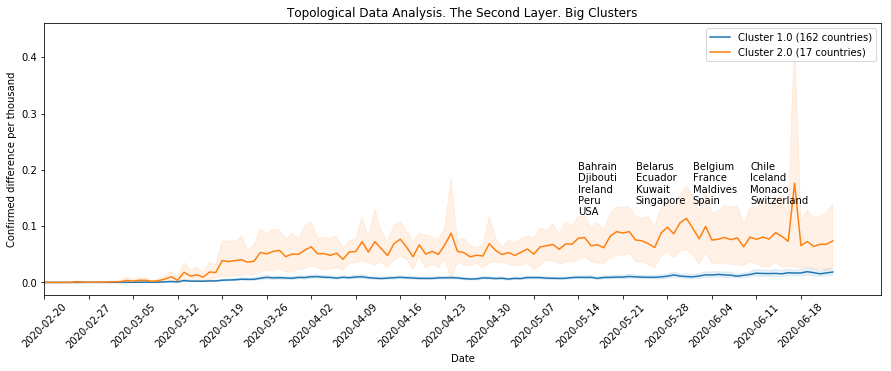

In [26]:
plt.figure(figsize=(15,5))
f = 'TDA_anomaly_diff_2'
for v in tda_ds[f].value_counts().index[:2]:
    pop_mean = cov_ds[cov_ds[f]==v].groupby('Country')['Population'].mean().median()
#    sns.lineplot(x='Date_dt', y='Confirmed_per_pop', data=cov_ds[cov_ds[f]==v],
    sns.lineplot(x='Date_dt', y='Confirmed_diff_per_kpop', data=cov_ds[cov_ds[f]==v],
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries)",
                 palette='Accent', err_kws={'alpha':0.1})
plt.xticks(xticks[4:], [str(x)[:10] for x in xticks][4:], rotation=45)
plt.xlim((xticks[4], plt.xlim()[-1]))
#plt.yticks(np.log1p(yticks), yticks)

for idx, cntry in enumerate(sorted(tda_ds[tda_ds[f]==2].index)):
    x_idx, y_idx = idx%4, idx//4
    cntry = cntry if cntry!="United Kingdom" else 'UK'
    cntry = cntry if cntry!='United States' else 'USA'
    plt.text(xticks[-6]+timedelta(days=x_idx*9), 2e-1-y_idx*2e-2, cntry)
    #plt.text(xticks[-6]+timedelta(days=x_idx*9), 0.005-y_idx*5e-4, cntry)
    #plt.text(xticks[-6]+timedelta(days=x_idx*9), 125000-y_idx*1e4, cntry)

plt.title(f"Topological Data Analysis. The Second Layer. Big Clusters")
plt.ylabel('Confirmed difference per thousand')
plt.xlabel('Date')
plt.show()

In [27]:
(tda_ds['TDA_anomaly_diff_2']==tda_ds['TDA_anomaly_diff_3']).mean()

0.3670212765957447

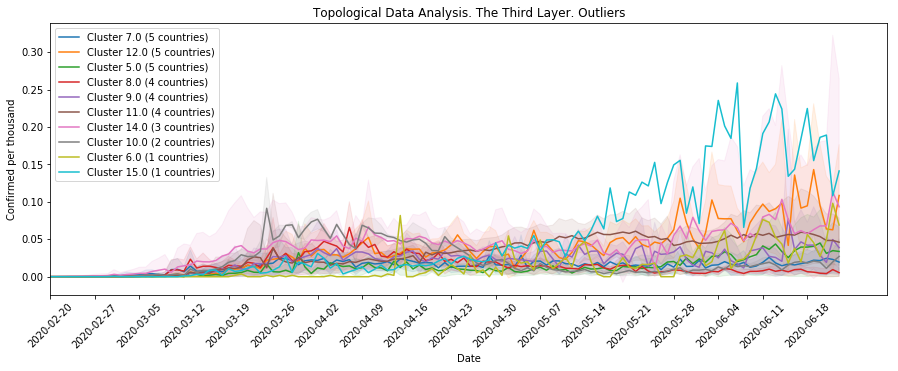

In [34]:
plt.figure(figsize=(15,5))
f = 'TDA_anomaly_diff_3'
for v in tda_ds[f].value_counts().index[5:]:
    #if v==0:
    #    continue
    pop_mean = cov_ds[cov_ds[f]==v].groupby('Country')['Population'].mean().median()
#    sns.lineplot(x='Date_dt', y='Confirmed_log', data=cov_ds[cov_ds[f]==v],
#                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries) (median pop: {pop_mean:.0f}"+" k)" if pop_mean is not None else ")",
    sns.lineplot(x='Date_dt', y='Confirmed_diff_per_kpop', data=cov_ds[cov_ds[f]==v],
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries)",
                 palette='Accent', err_kws={'alpha':0.1})
plt.xticks(xticks[4:], [str(x)[:10] for x in xticks][4:], rotation=45)
plt.xlim((xticks[4], plt.xlim()[-1]))
#plt.yticks(np.log1p(yticks), yticks)

#for v in tda_ds[f].value_counts().index[3:]:
    #if v==0:
    #    continue
#    mean = cov_ds.loc[(cov_ds[f]==v)&(cov_ds['Date_dt']==xticks[-1]), 'Confirmed_per_pop'].mean()
#    cntrs = ', '.join(list(tda_ds[tda_ds[f]==v].index))
#    plt.text(xticks[-2], mean, cntrs)
    #plt.text(xticks[-1], mean+0.1, f"Confirmed cases: {np.expm1(mean):.0f}")

plt.title(f"Topological Data Analysis. The Third Layer. Outliers")
plt.ylabel('Confirmed per thousand')
plt.xlabel('Date')
plt.show()

In [37]:
tda_ds[tda_ds['TDA_anomaly_diff_3']==15]

,TDA_anomaly_diff_1,TDA_anomaly_diff_2,TDA_anomaly_diff_3,TDA_final
Country,,,,
Armenia,1,1.0,15.0,NaN


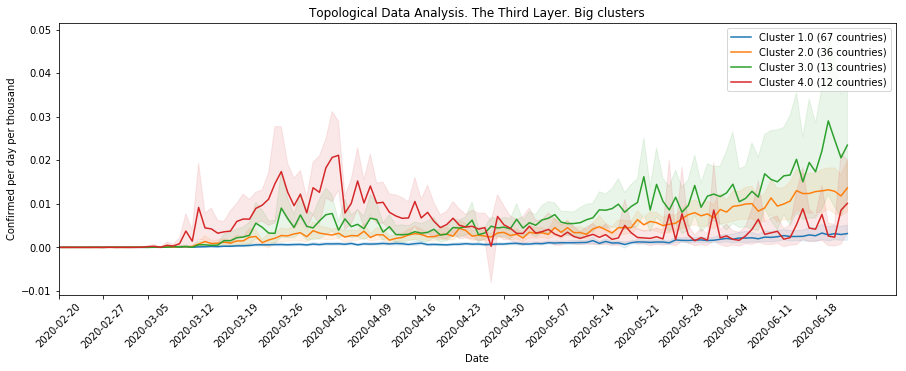

In [47]:
plt.figure(figsize=(15,5))
f = 'TDA_anomaly_diff_3'
for v in tda_ds[f].value_counts().index[:5]:
    if v==tda_ds[f].max():
        continue
    pop_mean = cov_ds[cov_ds[f]==v].groupby('Country')['Population'].mean().median()
    #sns.lineplot(x='Date_dt', y='Confirmed_log', data=cov_ds[cov_ds[f]==v],
    sns.lineplot(x='Date_dt', y='Confirmed_diff_per_kpop', data=cov_ds[cov_ds[f]==v],
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries)",
                 palette='Accent', err_kws={'alpha':0.1})
plt.xticks(xticks[4:], [str(x)[:10] for x in xticks][4:], rotation=45)
plt.xlim((xticks[4], plt.xlim()[-1]))
#plt.yticks(np.log1p(yticks), yticks)

#y_coord = cov_ds[(cov_ds['Date_dt']==xticks[-1])&(cov_ds['Country'].isin(tda_ds[tda_ds[f]==2].index))]['Confirmed'].mean()
y_coord = cov_ds[(cov_ds['Date_dt']==xticks[-1])&(cov_ds['Country'].isin(tda_ds[tda_ds[f]==2].index))]['Confirmed_diff_per_kpop'].mean()
for idx, cntry in enumerate(sorted(tda_ds[tda_ds[f]==2].index)):
    x_idx, y_idx = idx%6, idx//6
    cntry = cntry if cntry!="United Kingdom" else 'UK'
    cntry = cntry if cntry!='United States' else 'USA'
    #plt.text(xticks[-10]+timedelta(days=x_idx*10), np.log1p(y_coord)-y_idx*0.7, cntry)
#    plt.text(xticks[-10]+timedelta(days=x_idx*10), np.log1p(y_coord)-y_idx*1e-1, cntry)

plt.title(f"Topological Data Analysis. The Third Layer. Big clusters")
plt.ylabel('Confirmed per day per thousand')
plt.xlabel('Date')
plt.show()

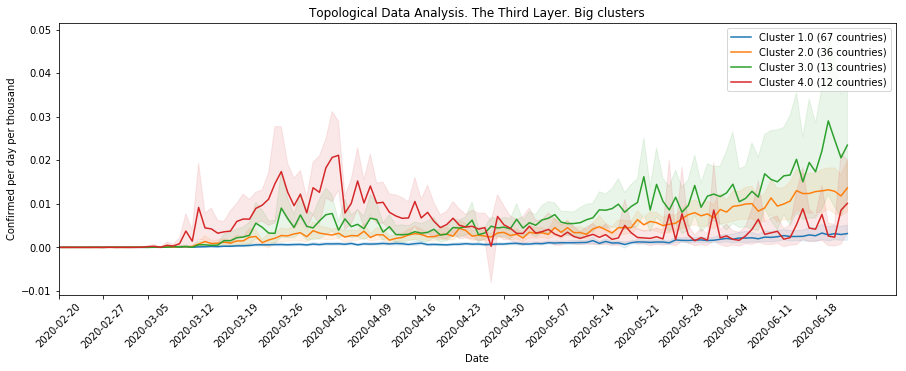

In [47]:
plt.figure(figsize=(15,5))
f = 'TDA_anomaly_diff_3'
for v in tda_ds[f].value_counts().index[:5]:
    if v==tda_ds[f].max():
        continue
    pop_mean = cov_ds[cov_ds[f]==v].groupby('Country')['Population'].mean().median()
    #sns.lineplot(x='Date_dt', y='Confirmed_log', data=cov_ds[cov_ds[f]==v],
    sns.lineplot(x='Date_dt', y='Confirmed_diff_per_kpop', data=cov_ds[cov_ds[f]==v],
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries)",
                 palette='Accent', err_kws={'alpha':0.1})
plt.xticks(xticks[4:], [str(x)[:10] for x in xticks][4:], rotation=45)
plt.xlim((xticks[4], plt.xlim()[-1]))
#plt.yticks(np.log1p(yticks), yticks)

#y_coord = cov_ds[(cov_ds['Date_dt']==xticks[-1])&(cov_ds['Country'].isin(tda_ds[tda_ds[f]==2].index))]['Confirmed'].mean()
y_coord = cov_ds[(cov_ds['Date_dt']==xticks[-1])&(cov_ds['Country'].isin(tda_ds[tda_ds[f]==2].index))]['Confirmed_diff_per_kpop'].mean()
for idx, cntry in enumerate(sorted(tda_ds[tda_ds[f]==2].index)):
    x_idx, y_idx = idx%6, idx//6
    cntry = cntry if cntry!="United Kingdom" else 'UK'
    cntry = cntry if cntry!='United States' else 'USA'
    #plt.text(xticks[-10]+timedelta(days=x_idx*10), np.log1p(y_coord)-y_idx*0.7, cntry)
#    plt.text(xticks[-10]+timedelta(days=x_idx*10), np.log1p(y_coord)-y_idx*1e-1, cntry)

plt.title(f"Topological Data Analysis. The Third Layer. Big clusters")
plt.ylabel('Confirmed per day per thousand')
plt.xlabel('Date')
plt.show()

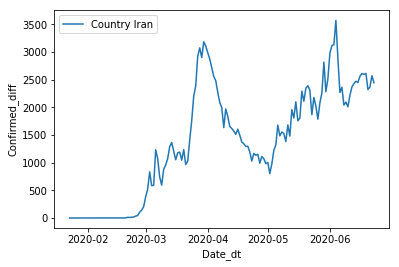

In [63]:
sns.lineplot(x='Date_dt', y='Confirmed_diff', data=cov_ds[cov_ds['Country']=='Iran'],
                 label=f"Country Iran",
                 palette='Accent', err_kws={'alpha':0.1})

In [70]:
tda_ds.loc['Iran']

TDA_anomaly_diff_1      1
TDA_anomaly_diff_2      1
TDA_anomaly_diff_3      7
TDA_final             NaN
Name: Iran, dtype: object

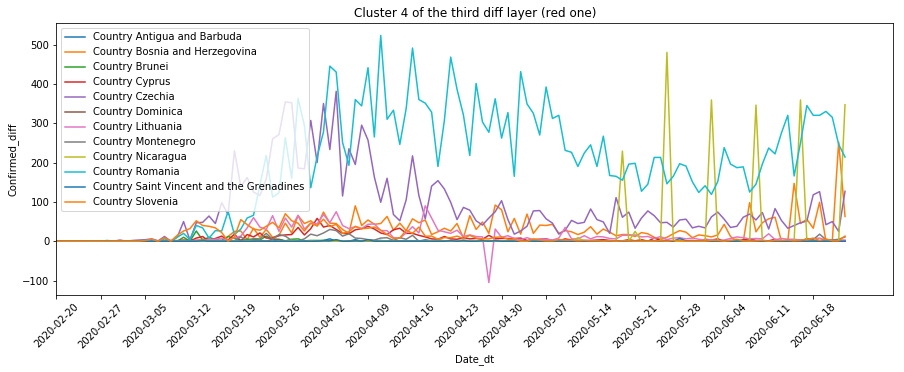

In [62]:
plt.figure(figsize=(15,5))
f = 'TDA_anomaly_diff_3'
for v in tda_ds[tda_ds['TDA_anomaly_diff_3']==4].index:
    if v==tda_ds[f].max():
        continue
    #sns.lineplot(x='Date_dt', y='Confirmed_log', data=cov_ds[cov_ds[f]==v],
    sns.lineplot(x='Date_dt', y='Confirmed_diff', data=cov_ds[cov_ds['Country']==v],
                 label=f"Country {v}",
                 palette='Accent', err_kws={'alpha':0.1})
plt.xticks(xticks[4:], [str(x)[:10] for x in xticks][4:], rotation=45)
plt.xlim((xticks[4], plt.xlim()[-1]))
plt.title('Cluster 4 of the third diff layer (red one)')
plt.show()

In [60]:
cov_ds.loc[(cov_ds['Country']=='Lithuania')&(cov_ds['Date_dt']>='2020-04-23')][['Date','Confirmed','Confirmed_diff']]

,Date,Confirmed,Confirmed_diff
15338,04/23/2020,1398,28.0
15339,04/24/2020,1410,12.0
15340,04/25/2020,1426,16.0
15341,04/26/2020,1438,12.0
15342,04/27/2020,1449,11.0
15343,04/28/2020,1344,-105.0
15344,04/29/2020,1375,31.0
15345,04/30/2020,1385,10.0
15346,05/01/2020,1399,14.0
15347,05/02/2020,1406,7.0


In [48]:
tda_ds[tda_ds['TDA_anomaly_diff_3']==4]

,TDA_anomaly_diff_1,TDA_anomaly_diff_2,TDA_anomaly_diff_3,TDA_final
Country,,,,
Antigua and Barbuda,1,1.0,4.0,NaN
Bosnia and Herzegovina,1,1.0,4.0,NaN
Brunei,1,1.0,4.0,NaN
Cyprus,1,1.0,4.0,NaN
Czechia,1,1.0,4.0,NaN
Dominica,1,1.0,4.0,NaN
Lithuania,1,1.0,4.0,NaN
Montenegro,1,1.0,4.0,NaN
Nicaragua,1,1.0,4.0,NaN


In [46]:
tda_ds[]

,TDA_anomaly_diff_1,TDA_anomaly_diff_2,TDA_anomaly_diff_3,TDA_final
Country,,,,
Afghanistan,1,1.0,2.0,NaN
Albania,1,1.0,2.0,NaN
Algeria,1,1.0,1.0,NaN
Andorra,1,5.0,16.0,NaN
Angola,1,1.0,1.0,NaN
Antigua and Barbuda,1,1.0,4.0,NaN
Argentina,1,1.0,2.0,NaN
Armenia,1,1.0,15.0,NaN
Australia,1,1.0,2.0,NaN


In [698]:
f = 'TDA_final'
d = tda_ds[f].to_dict()
cov_ds[f] = cov_ds['Country'].apply(lambda x: d[x])

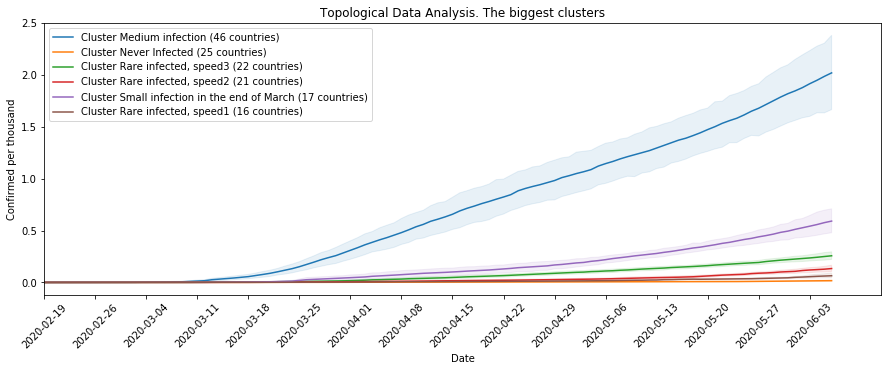

In [699]:
plt.figure(figsize=(15,5))
f = 'TDA_final'
for v in tda_ds[f].value_counts().index[:6]:
    if v==tda_ds[f].max():
        continue
 #   sns.lineplot(x='Date_dt', y='Confirmed_log', data=cov_ds[cov_ds[f]==v],
    sns.lineplot(x='Date_dt', y='Confirmed_per_kpop', data=cov_ds[cov_ds[f]==v],
                 label=f"Cluster {v} ({(tda_ds[f]==v).sum()} countries)",
                 palette='Accent', err_kws={'alpha':0.1})
plt.xticks(xticks[4:], [str(x)[:10] for x in xticks][4:], rotation=45)
plt.xlim((xticks[4], plt.xlim()[-1]))
#plt.yticks(np.log1p(yticks), yticks)

#y_coord = cov_ds[(cov_ds['Date_dt']==xticks[-1])&(cov_ds['Country'].isin(tda_ds[tda_ds[f]==2].index))]['Confirmed'].mean()
#for idx, cntry in enumerate(sorted(tda_ds[tda_ds[f]==2].index)):
#    x_idx, y_idx = idx%6, idx//6
#    cntry = cntry if cntry!="United Kingdom" else 'UK'
#    cntry = cntry if cntry!='United States' else 'USA'
#    plt.text(xticks[-10]+timedelta(days=x_idx*10), np.log1p(y_coord)-y_idx*0.7, cntry)

plt.title(f"Topological Data Analysis. The biggest clusters")
plt.ylabel('Confirmed per thousand')
plt.xlabel('Date')
plt.show()

In [700]:
d = cov_ds[cov_ds['Date_dt']==xticks[-1]][
    ['Country','TDA_final','Confirmed_per_kpop']].drop_duplicates().groupby('TDA_final')[
    'Confirmed_per_kpop'].mean().fillna(0).sort_values(ascending=True)
d = pd.Series([idx for idx, x in enumerate(d.index)], index=d.index)

In [701]:
tda_ds['TDA_final_code'] = tda_ds['TDA_final'].apply(lambda x: d.to_dict()[x])

In [702]:
tda_ds['TDA_final_short'] = None
tda_ds.loc[tda_ds['TDA_final'].isin(['Medium infection']), 'TDA_final_short'] = 'Medium infection'
tda_ds.loc[tda_ds['TDA_final'].isin(['Never Infected']), 'TDA_final_short'] = 'Never Infected'
tda_ds.loc[tda_ds['TDA_final'].isin(['Rare infected, speed4','Rare infected, speed3']), 'TDA_final_short'] = 'Rare infected, high speed'
tda_ds.loc[tda_ds['TDA_final'].isin(['Rare infected, speed1','Rare infected, speed2']), 'TDA_final_short'] = 'Rare infected, slow speed'
tda_ds.loc[tda_ds['TDA_final'].isin(['The most infected']), 'TDA_final_short'] = 'The most infected'
tda_ds.loc[tda_ds['TDA_final'].isin(['Ships','Holy See']), 'TDA_final_short'] = 'Quasi countries'
tda_ds.loc[tda_ds['TDA_final'].isin(['Small infection in the end of March']), 'TDA_final_short'] = 'Small infection in the end of March'
tda_ds.loc[tda_ds['TDA_final_short'].isna(), 'TDA_final_short'] = 'Outliers'

In [704]:
f = 'TDA_final_short'
d = tda_ds[f].to_dict()
cov_ds[f] = cov_ds['Country'].apply(lambda x: d[x])

In [705]:
d = cov_ds[cov_ds['Date_dt']==xticks[-1]][
    ['Country','TDA_final_short','Confirmed_per_kpop']].drop_duplicates().groupby('TDA_final_short')[
    'Confirmed_per_kpop'].mean().fillna(0).sort_values(ascending=True)
d = pd.Series([idx for idx, x in enumerate(d.index)], index=d.index)

In [706]:
tda_ds['TDA_final_short_code'] = tda_ds['TDA_final_short'].apply(lambda x: d.to_dict()[x])

In [709]:
tda_ds.to_csv('../TDA_confirmed_anomalies.csv')